In [28]:
import xarray as xr
import geopandas as gpd
import dask
import numpy as np

from skill import recorte
from skill import clima
from skill import plot
from skill import config

# Configurando diretorios

In [2]:
dir_dados = config.dir_dados
dir_img = config.dir_img
dir_shp = config.dir_shp

# Abrindo arquivos

In [3]:
gpcc = xr.open_dataset(f'{dir_dados}/precip.comb.v2020to2019-v2020monitorafter.total.nc')
br_madeira = gpd.read_file(f'{dir_shp}/brasil_madeira.shp')

clima_cam = xr.open_dataset(f'{dir_dados}/cam3_clima.nc')
clima_cam['chuva'] = (clima_cam.PRECC + clima_cam.PRECSH + clima_cam.PRECL)*3600*24*30*1000 #cria chuva total com as variaveis do dataset

## Abrindo arquivo de previsão p/ utilizar lat e lon p/ interpolacao da climatologia e do observado

A climatologia tem mesma resolução que as previsões do CAM. Entretanto, os pontos de grade não são os mesmos. Isso acaba causando problemas na hora de calcular a anomalia, já que a indexação é feita pelo conjunto lat lon.

In [4]:
aux = xr.open_dataset(f'{dir_dados}/cam3_init1.nc')

lat = aux.lat.values
lon = aux.lon.values

In [5]:
clima_cam = recorte.regridder(clima_cam, lat, lon)

# Trabalhando com observado

## Calcula anomalia

Climatologia escolhida para ter mesma data da climatologia do CAM de acordo com Vasconcellos (2017).

In [6]:
clima_obs = clima.climatologia(gpcc, '1979-01-01', '1999-12-01')
obs = gpcc.sel(time=slice('2012-01-01', '2020-12-01'))

anom_obs = clima.anomalia(obs, clima_obs)

## Interpola para a grade do cam

In [7]:
anom_obs_interp = recorte.regridder(anom_obs, lat, lon)
anom_obs_br = recorte.recortar(anom_obs_interp, br_madeira)

# Trabalhando com dado do cam

In [8]:
cam = xr.open_dataset(f'{dir_dados}/cam3_init1.nc')
cam['chuva'] = (cam.PRECC + cam.PRECSH + cam.PRECL)*3600*24*30*1000

cam_anom = clima.anomalia(cam.chuva, clima_cam.chuva.groupby('time.month').mean())
cam_anom['time'] = cam_anom.indexes['time'].to_datetimeindex()

cam_anom_br = recorte.recortar(cam_anom, br_madeira)

/tmp/ipykernel_2565/3974625803.py:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cam_anom['time'] = cam_anom.indexes['time'].to_datetimeindex()


In [11]:
ds_camcorr = cam_anom_br.sel(time=cam_anom_br.time.dt.month == 2, lead=1)
ds_obscorr = anom_obs_br.sel(time=anom_obs_br.time.dt.month == 2).precip

/home/mvictor/miniconda3/envs/tcc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mvictor/miniconda3/envs/tcc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


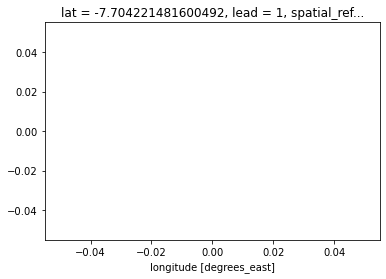

In [49]:
xr.corr(ds_camcorr, ds_obscorr, dim='time').plot()